In [9]:
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib import rc
from matplotlib import ticker
from matplotlib import dates as mdates

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

sys.path.append('./utils')

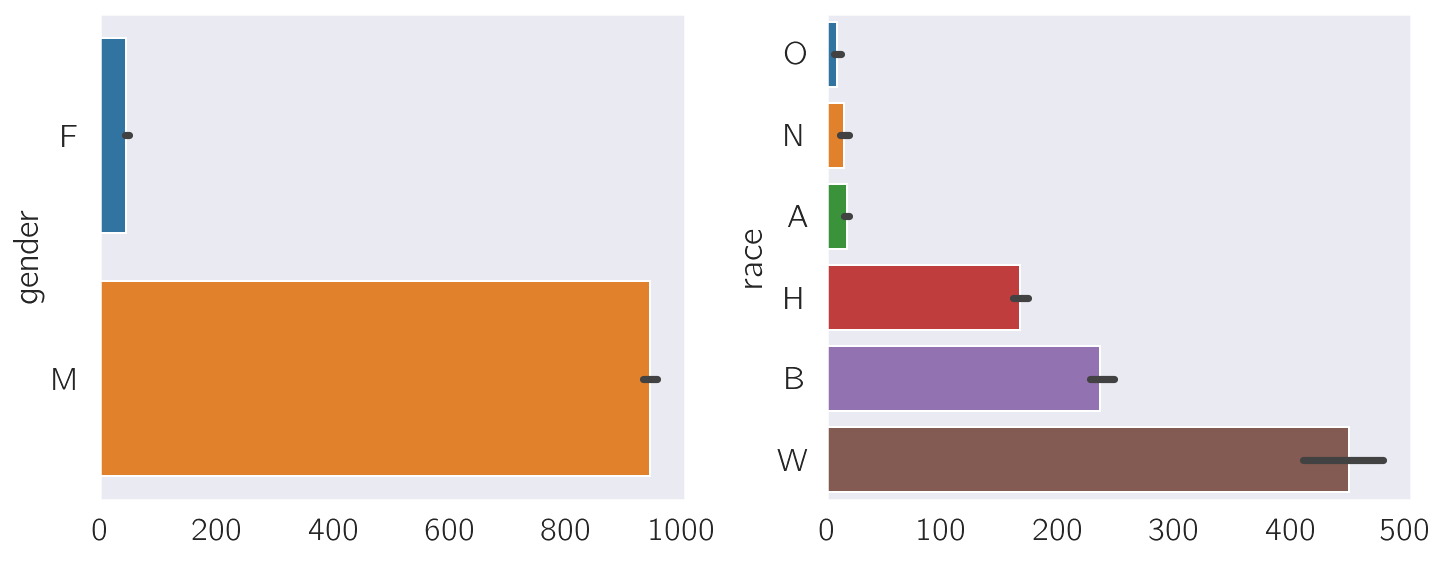

In [158]:
f = 'YS'

# fetch WaPo data:
url = 'https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/fatal-police-shootings-data.csv'
df = pd.read_csv(url, parse_dates=['date'])
pop = pd.read_excel('../data/nst-est2019-01.xlsx', comment='#', header=1)
us_state_abbrev = { 'Alabama': 'AL', 'Alaska': 'AK', 'American Samoa': 'AS', 'Arizona': 'AZ',
                    'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT',
                    'Delaware': 'DE', 'District of Columbia': 'DC','Florida': 'FL', 'Georgia': 'GA',
                    'Guam': 'GU', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN',
                    'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME',
                    'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN',
                    'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
                    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
                    'North Carolina': 'NC', 'North Dakota': 'ND', 'Northern Mariana Islands':'MP',
                    'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Puerto Rico': 'PR',
                    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
                    'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virgin Islands': 'VI', 'Virginia': 'VA',
                    'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
                  }

# fetch NYT data:
pop.columns = np.append(np.array(['state']), pop.columns[1:].values)
pop.state = pop.state.str.strip('.')
pop.state = pop.state.map(us_state_abbrev)
df = df.merge(pop, left_on='state', right_on='state')
df['year'] = pd.DatetimeIndex(df.date).year
df = df[df.year != 2020]

def count_by_att(attribute, df=df, popcols=False):
    tmp = df.copy()
    tmp.dropna(subset=['id', attribute, 'year'], inplace=True)
    tmp['total'] = tmp.groupby([attribute, 'year']).id.transform(lambda x: len(x))
    
    if popcols is False:
        cols = ['year', attribute, 'total']
    else:
        cols = ['year', attribute, 'total'] + [p for p in pop.columns]
    return tmp[cols].drop_duplicates().sort_values('total')

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0] = sns.barplot(x='total', y='gender', data=count_by_att('gender'), ax=ax[0])
ax[1] = sns.barplot(x='total', y='race', data=count_by_att('race'), ax=ax[1])

ax[0].set_xlabel('')
ax[1].set_xlabel('')
plt.tight_layout()

In [161]:
f = 'M'

deaths_by_f = df.groupby(pd.Grouper(key='date', freq=f)).id.count().values
dates = df.groupby(pd.Grouper(key='date', freq=f)).id.count().index.values

# season = pd.DataFrame(list(zip(deaths_by_f, dates)), columns=['Deaths', 'Date'])

# plt.plot(count_by_att('age').age, count_by_att('age').id / count_by_att('age').id.sum(), '*')
# plt.plot(count_by_att('age', df=df[df.race == 'B']).age,
#          count_by_att('age', df=df[df.race == 'B']).id / count_by_att('age', df=df[df.race == 'B']).id.sum(), 'o', color='black')
# plt.plot(count_by_att('age', df=df[df.race == 'H']).age,
#          count_by_att('age', df=df[df.race == 'H']).id / count_by_att('age', df=df[df.race == 'B']).id.sum(), 'd', color='brown')

(array([735780., 735964., 736146., 736330., 736511., 736695., 736876.,
        737060., 737241., 737425.]), <a list of 10 Text xticklabel objects>)

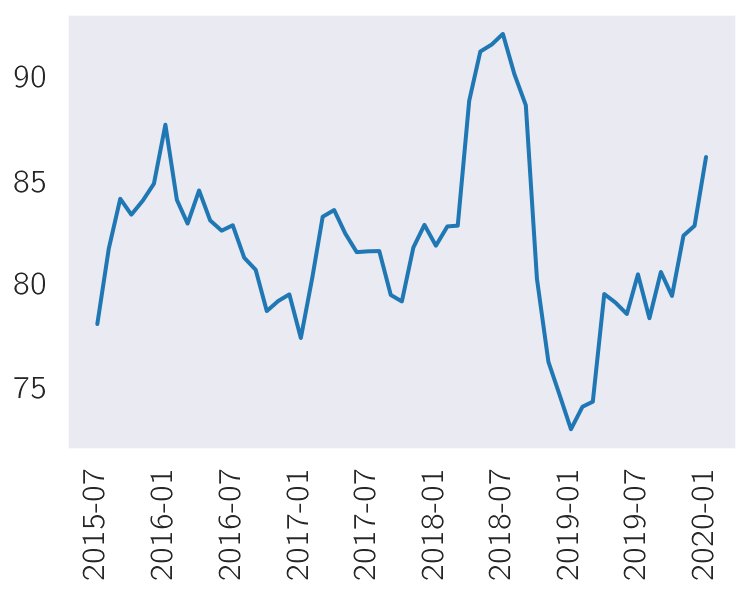

In [168]:
f = 'W'
window = 6
tau = 10
season['RefTime'] = season.groupby(pd.Grouper(key='Date',freq='YS')).Date.transform(lambda x:
                                         (x - x.min()) / dt.timedelta(days=1))
season['Smooth'] = season.Deaths.rolling(window=window, win_type='exponential').mean(tau=tau)

plt.plot(season.Date, season.Smooth)
plt.xticks(rotation=90)

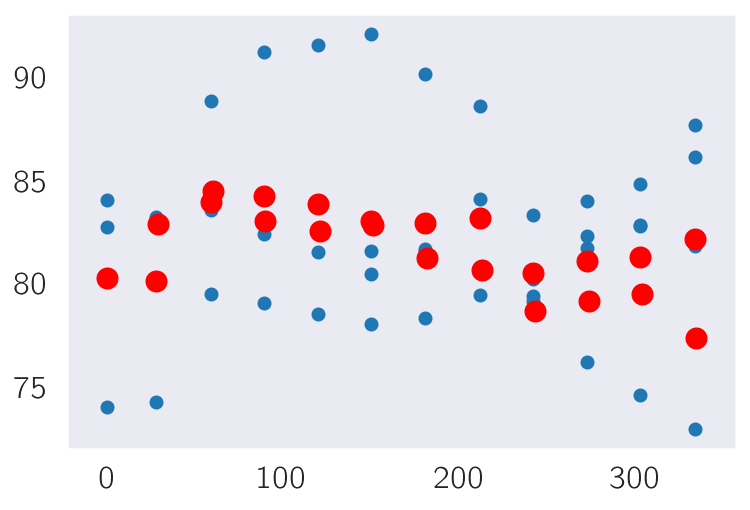

In [194]:
plt.scatter(season.RefTime, season.Smooth)
plt.scatter(season.sort_values('RefTime').RefTime.unique(),
            season.sort_values('RefTime').groupby('RefTime').Smooth.apply(np.mean),
            color='red', s=100)

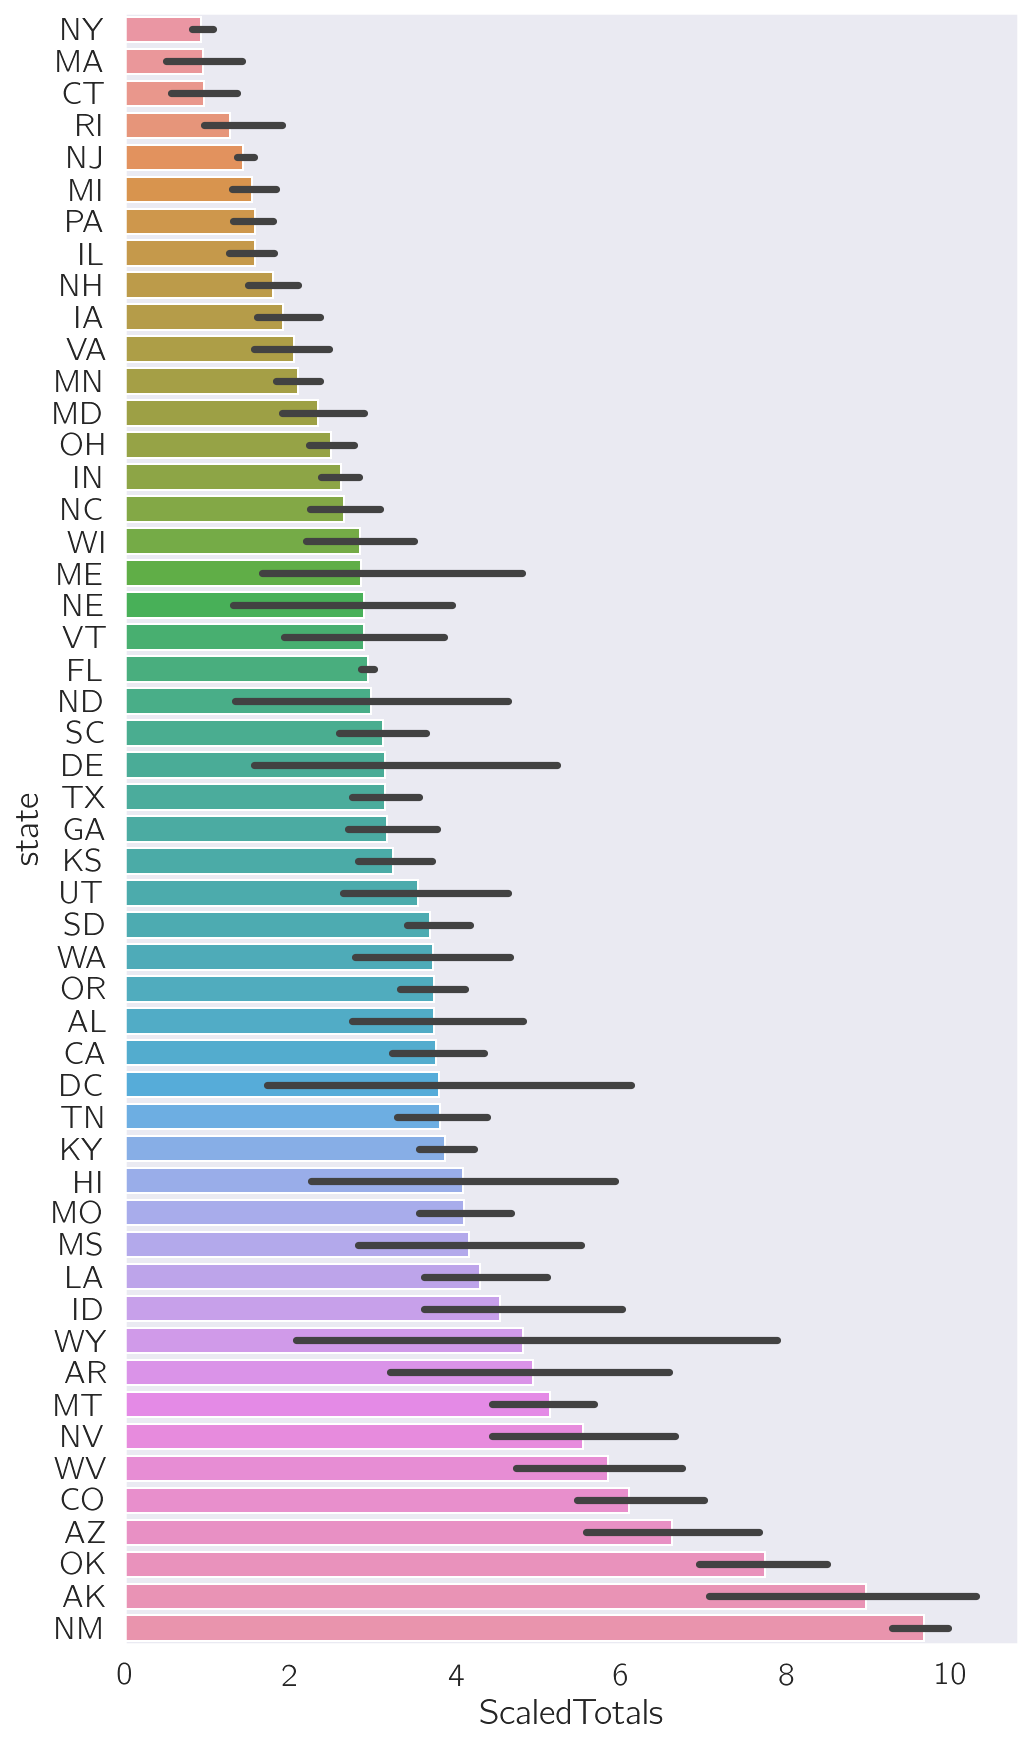

In [195]:
df['state_totals_per_year'] = df.groupby(['state', 'year']).id.transform(lambda x: x.count())
tmp = df[['state', 'year', 'state_totals_per_year', 2015, 2016, 2017, 2018, 2019]].drop_duplicates()

def norm_factor(state, year):
    if year in pop.columns:
        return pop[(pop.state == state)][year].values[0]
    else:
        return np.nan

tmp['norm_factor'] = tmp.apply(lambda x: norm_factor(x.state, x.year), axis=1)
tmp['scaled_totals'] = 10 ** 6 * tmp.state_totals_per_year / tmp.norm_factor
tmp['mean'] = tmp.groupby('state').scaled_totals.transform(np.mean)

fig, ax = plt.subplots(figsize=(8, 15))
sns.barplot(x='ScaledTotals', y='state',
            data=tmp.sort_values('mean').rename(columns={'scaled_totals':
                                                         'ScaledTotals'}))

In [196]:
tmp

,state,year,state_totals_per_year,2015,2016,2017,2018,2019,norm_factor,scaled_totals,mean
0,WA,2015,16,7163657.0,7294771.0,7423362.0,7523869.0,7614893.0,7163657.0,2.233496,3.713655
16,WA,2016,26,7163657.0,7294771.0,7423362.0,7523869.0,7614893.0,7294771.0,3.564197,3.713655
42,WA,2017,38,7163657.0,7294771.0,7423362.0,7523869.0,7614893.0,7423362.0,5.118974,3.713655
80,WA,2018,22,7163657.0,7294771.0,7423362.0,7523869.0,7614893.0,7523869.0,2.924028,3.713655
102,WA,2019,36,7163657.0,7294771.0,7423362.0,7523869.0,7614893.0,7614893.0,4.727578,3.713655
...,...,...,...,...,...,...,...,...,...,...,...
5357,VT,2018,2,625216.0,623657.0,624344.0,624358.0,623989.0,624358.0,3.203290,2.883817
5359,VT,2019,3,625216.0,623657.0,624344.0,624358.0,623989.0,623989.0,4.807777,2.883817
5362,RI,2016,2,1056065.0,1056770.0,1055673.0,1058287.0,1059361.0,1056770.0,1.892559,1.261582
5364,RI,2017,1,1056065.0,1056770.0,1055673.0,1058287.0,1059361.0,1055673.0,0.947263,1.261582


In [44]:
count_by_att('gender')

,gender,date,id,Year
5,F,2020-01-01,13,2020
1,F,2016-01-01,40,2016
0,F,2015-01-01,42,2015
4,F,2019-01-01,43,2019
2,F,2017-01-01,45,2017
3,F,2018-01-01,52,2018
11,M,2020-01-01,415,2020
7,M,2016-01-01,922,2016
9,M,2018-01-01,939,2018
8,M,2017-01-01,940,2017


In [ ]:
{'United States': 'US', 'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticute': 'CT',
 'Delaware', 'DE', 'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI'}